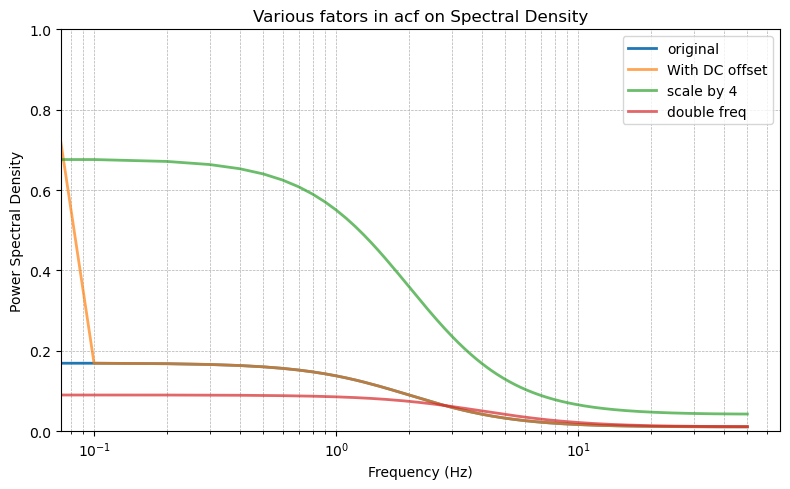

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# --- Create a test signal ---
np.random.seed(0)
t = np.linspace(0, 10, 1000)
#signal = np.sin(2 * np.pi * 2 * t) + 0.5 * np.random.randn(len(t))  # oscillatory + noise
signal = np.exp(-2 * np.pi * 2 * t)
signal_with_offset = signal + 200.0  # constant offset
signal2=4*np.exp(-2 * np.pi * 2 * t)
signal3= np.exp(-2 * np.pi * 4 * t)

# --- Compute spectral density via FFT ---
def spectral_density(x, dt):
    N = len(x)
    xf = np.fft.rfftfreq(N, d=dt)
    #psd = np.abs(np.fft.fft(x))**2 / N
    fft_result = np.fft.rfft(x, n=N, axis=0)

    # Real spectral density (normalized properly)
    J = 2 * dt * np.real(fft_result)
    return xf, J  # keep positive frequencies

dt = t[1] - t[0]
xf_no_offset, psd_no_offset = spectral_density(signal, dt)
xf_with_offset, psd_with_offset = spectral_density(signal_with_offset, dt)
xf_no_offset2, psd_no_offset2 = spectral_density(signal2, dt)
xf_no_offset3, psd_no_offset3 = spectral_density(signal3, dt)

# --- Plot results ---
plt.figure(figsize=(8,5))
plt.plot(xf_no_offset, psd_no_offset, label='original', lw=2)
plt.plot(xf_with_offset, psd_with_offset, label='With DC offset', lw=2, alpha=0.7)
plt.plot(xf_no_offset2, psd_no_offset2,label='scale by 4', lw=2, alpha=0.7 )
plt.plot(xf_no_offset3, psd_no_offset3,label='double freq', lw=2, alpha=0.7 )

plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.ylim(-0, 1)
plt.legend()
plt.title('Various fators in acf on Spectral Density')
plt.grid(True, which='both', ls='--', lw=0.5)
plt.tight_layout()
plt.show()
